### **4 Feature engineering of the target variable and model testing**
Our next step in the process of building a model to predict if an item is going to be returned or not, will include feature engineering of the categorical variables and building the base models.
Our dataset contains numerous categorical variables, which depending on the model we use, must be encoded in a specific way in order for the model to be able to interpret them. Furthermore, some of the categorical variables such as **item_id**, **user_id**, **brand_id** possess a large number of unique values or in other words said these variables have high **cardinality**. In order to make use of them we will use a technique called **"target encoding"**, which in its essence is a technique to reduce the cardinality of the categorical variables by replacing all unique values of a variable with its **target mean**.

In [1]:
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette = "Dark2")
# import datetime
import warnings
from scipy.stats import ttest_ind
my_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
  (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)]
from sklearn.feature_selection import RFECV
pd.set_option('display.max_columns', None)
from itertools import chain, combinations

d:\miniconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import tensorflow as tensorflow
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

#### **4.1 One hot encoding**

In [3]:
df = pd.read_csv("df_processed.csv")
# temporary
# df.drop(['order_id'], axis=1, inplace=True)
df

,order_item_id,order_date,delivery_date,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,delivery_time,order_id,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,average_item_price_order,order_item_count,order_sum,order_number_same_item_id,order_number_different_item_id,order_number_same_size,order_number_different_size,order_number_same_item_color,order_number_different_item_color,order_number_same_brand_id,order_number_different_brand_id,order_number_same_item_id_size,order_number_different_item_id_size,order_number_same_item_id_item_color,order_number_different_item_id_item_color,order_number_same_size_item_color,order_number_different_size_item_color,order_number_same_size_brand_id,order_number_different_size_brand_id,order_number_same_item_color_brand_id,order_number_different_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_different_item_id_size_item_color,order_number_same_size_item_color_brand_id,order_number_different_size_item_color_brand_id
0,1,2012-04-01,2012-04-03,186,s,denim,25,69.90,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,0.0,2,2012-04-01_794,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3
1,2,2012-04-01,2012-04-03,71,unsized,ocher,21,69.95,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,1.0,2,2012-04-01_794,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3
2,3,2012-04-01,2012-04-03,71,unsized,curry,21,69.95,794,Mrs,1965-01-06,Bad-Wue,2011-04-25,1.0,2,2012-04-01_794,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3
3,4,2012-04-02,2012-04-06,22,s,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0.0,4,2012-04-02_808,52,89,0,4,4,4,2,6,14,14,39.90,1,39.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,5,2012-04-02,2012-04-06,151,s,black,53,29.90,825,Mrs,1964-07-11,S-Holstein,2011-02-16,0.0,4,2012-04-02_825,48,411,0,4,4,4,2,6,14,14,83.23,3,249.7,0,3,1,2,1,2,0,3,0,3,0,3,1,2,0,3,0,3,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531165,50074,2013-04-29,2013-05-03,2342,s,terracotta,5,69.90,91920,Mrs,1962-03-08,Bayern,2013-04-29,NaN,4,2013-04-29_91920,51,0,0,4,4,5,29,3,18,18,83.13,9,748.2,0,9,4,5,2,7,3,6,0,9,0,9,2,7,3,6,2,7,0,9,2,7
531166,50075,2013-04-29,2013-05-03,2505,s,terracotta,5,64.90,91920,Mrs,1962-03-08,Bayern,2013-04-29,NaN,4,2013-04-29_91920,51,0,0,4,4,5,29,3,18,18,83.13,9,748.2,1,8,4,5,2,7,3,6,1,8,1,8,2,7,3,6,2,7,1,8,2,7
531167,50076,2013-04-28,2013-05-02,2470,l,white,5,79.90,85095,Mrs,1950-02-14,Berlin,2013-03-24,NaN,4,2013-04-28_85095,63,35,6,3,4,5,28,2,17,18,79.90,1,79.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
531168,50077,2013-04-28,2013-05-02,2452,m,white,5,59.90,91922,Mrs,1969-11-27,Bburg,2013-04-28,NaN,4,2013-04-28_91922,43,0,6,3,4,5,28,2,17,18,59.90,2,119.8,1,1,1,1,0,2,1,1,1,1,0,2,0,2,1,1,0,2,0,2,0,2


In [37]:
low_cardinality_cat_cols = ["size","item_color","user_title","user_state"]
high_cardinality_cat_cols = ["item_id","brand_id","user_id"]
cat_cols = low_cardinality_cat_cols + high_cardinality_cat_cols
# size of the known dataset
k = max(df["order_item_id"])-1

We are going to divide our dataset into two sets: **train** and **test**. We will use the **train** set to build our model and the **test** set to evaluate its performance. It is important to split the data "manually" and not use randomized train test split, because we want to avoid target leakage and prevent overfitting of the model, since every single item is a part of a specific order and many customers are one time buyers. If we split the data randomly, we will mix the items in the train and test sets in a way that violates our assumptions, and end up with a model that is not able to generalize to new data. For example if an item in the test set was bought from a one-time buyer, that has returned all his items, then the model will be able to predict that he will also most likely return the item as well.

In [67]:
# Divide the data into train and test sets
columns_to_drop = ["order_date", "delivery_date", "user_dob", "user_reg_date", "order_id","order_item_id"]
df.drop(columns_to_drop, axis=1, inplace=True)
df_valid = df.iloc[k:, :]
# df_train,df_test = df.loc[:k][df.loc[:k,"order_month"] != 3],df.loc[:k][df.loc[:k,"order_month"] == 3]

In order for some of our models to be able to interpret the categorical variables, we will use **"one_hot_encoding"** to encode the categorical variables. This is a technique that involves replacing each **unique value** of a variable with a binary vector of size equal to the number of **unique values** of the variable. For example, if a variable has 3 unique values, then the binary vector will be of size 3. If the value of the variable is 1, then the first element of the vector will be 1 and the others will be 0. If the value of the variable is 2, then the second element of the vector will be 1 and the others will be 0.

In [68]:
# Use one hot encoding to encode the categorical variables including only variables with frequency more than 50
def one_hot_encoding(df):
    transformer =   make_column_transformer(
                    (OneHotEncoder(min_frequency=50,drop= "first"), ['size', 'item_color',"user_title","user_state"]),
                    remainder='passthrough')
    transformed_fitted = transformer.fit_transform(df)
    transformed_df = pd.DataFrame(transformed_fitted, columns=transformer.get_feature_names())
    return transformed_df

#### **4.2 Defining the models**

As base models, we are going to use **LightGBM**, **XGBoost**, **CatBoost** and **Neural Network**. **LightGBM** and **CatBoost**** can handle categorical variables as long as they are of type "category" **Xgboost** and **Neural Networks** do not support them natively, thus we need to one-hot encode them.

In [136]:
# Xgboost classifier to train the model and use ROC as the metric
def xgboost_classifier(df, cat_cols):
    if cat_cols:
        df_cat = one_hot_encoding(df)
    else:
        df_cat = df
    df_train,df_test = df_cat.loc[:k][df_cat.loc[:k,"order_month"] != 3],df_cat.loc[:k][df_cat.loc[:k,"order_month"] == 3]
    X_train, Y_train = df_train.drop(["return"],axis=1), df_train["return"]
    X_test, Y_test = df_test.drop(["return"],axis=1), df_test["return"]
    
    model = XGBClassifier(max_depth=7, n_estimators=50, learning_rate=0.1,
                            n_jobs=-1, random_state=42)
    model.fit(X_train, Y_train, eval_metric='auc', eval_set=[(X_test, Y_test)],early_stopping_rounds = 20,verbose = 0)
    Y_pred = model.predict(X_test)
    auc = roc_auc_score(Y_test, Y_pred)
    print("Xgboost AUC on test set:", auc)
    return model,auc

In [126]:
# Catboost classifier to train the model and use ROC as the metric
def catboost_classifier(df,cat_cols):
    df_train,df_test = df.loc[:k][df.loc[:k,"order_month"] != 3],df.loc[:k][df.loc[:k,"order_month"] == 3]
    X_train, Y_train = df_train.drop(["return"],axis=1), df_train["return"]
    X_test, Y_test = df_test.drop(["return"],axis=1), df_test["return"]
    model = CatBoostClassifier(iterations=50, learning_rate=0.1, depth=10,
                            loss_function='Logloss', eval_metric='AUC',
                            random_seed=42)
    pool_train = Pool(X_train, Y_train,cat_features = cat_cols)

    pool_test = Pool(X_test, Y_test,cat_features = cat_cols)
    

    
    model.fit(pool_train, eval_set=pool_test, use_best_model=True, verbose=False)
    Y_pred = model.predict(pool_test)
    auc = roc_auc_score(Y_test, Y_pred)
    print("Catboost AUC on test set:", auc)
    return model,auc

In [62]:
# LightGBM
def lightgbm(df,cat_cols):
    df_cat_int = df.copy()
    for i in cat_cols:
        df_cat_int[i] = df_cat_int[i].astype('category')
    
    df_train,df_test = df_cat_int.loc[:k][df_cat_int.loc[:k,"order_month"] != 3],df_cat_int.loc[:k][df_cat_int.loc[:k,"order_month"] == 3]
    X_train, Y_train = df_train.drop(["return"],axis=1), df_train["return"]
    X_test, Y_test = df_test.drop(["return"],axis=1), df_test["return"]
    
    model = LGBMClassifier(boosting_type='gbdt')
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    auc = roc_auc_score(Y_test, Y_pred)
    print("LGBM AUC on test set: ", auc)
    return model,auc

In [63]:
# Neural network to train the model and use ROC as the metric
def neural_network(df,epochs,cat_cols):
    if cat_cols:
        df_cat = one_hot_encoding(df)
    else:
        df_cat = df
    df_train,df_test = df_cat.loc[:k][df_cat.loc[:k,"order_month"] != 3],df_cat.loc[:k][df_cat.loc[:k,"order_month"] == 3]
    X_train, Y_train = df_train.drop(["return"],axis=1), df_train["return"]
    X_test, Y_test = df_test.drop(["return"],axis=1), df_test["return"]

    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    auc = tensorflow.keras.metrics.AUC()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])
    
    results = model.fit(X_train, Y_train, epochs=epochs, batch_size=256, verbose=1,validation_data=(X_test, Y_test))
    Y_pred = model.predict(X_test)
    auc_1 = roc_auc_score(Y_test, Y_pred)
    print("ROC on test set:", auc_1)
     
    return model,auc_1, results.history[auc.name], results.history['val_'+auc.name]


In [52]:
# Get feature importance from the tree-based models
def get_feature_importance(model,df):
    return list(sorted(zip(df.columns.drop("return"), model.feature_importances_), key=lambda xx: xx[1], reverse=True))

#### **4.3 Fitting the models**
In this subsection we will fit the models and evaluate their performance using the Area Under the Receiver Operating Characteristic (AUROC) or also known as Area Under the Curve (AUC) as a metric. The plot of the receiver operating characteristic (ROC) curve is a graphical method of visualizing the performance of a binary classifier model. The ROC curve is a plot of the true positive rate against the false positive rate. The AUC is the area under the ROC curve and it can take values between 0 and 1. A model with an AUC of 1 is a perfect model and a model with an AUC of 0 is a model that never makes correct prediction.  


<p align="center">
  <img src="Roc_curve.png"  width=700 />
</p>

In [72]:
catboost_model,catboost_auc = catboost_classifier(df.iloc[:k, :],cat_cols)

0:	test: 0.6923831	best: 0.6923831 (0)	total: 1.43s	remaining: 1m 10s
1:	test: 0.7014465	best: 0.7014465 (1)	total: 2.53s	remaining: 1m
2:	test: 0.7026815	best: 0.7026815 (2)	total: 3.31s	remaining: 51.9s
3:	test: 0.7198298	best: 0.7198298 (3)	total: 4.18s	remaining: 48.1s
4:	test: 0.7240659	best: 0.7240659 (4)	total: 4.68s	remaining: 42.1s
5:	test: 0.7270989	best: 0.7270989 (5)	total: 5.27s	remaining: 38.7s
6:	test: 0.7271718	best: 0.7271718 (6)	total: 5.8s	remaining: 35.6s
7:	test: 0.7269371	best: 0.7271718 (6)	total: 6.22s	remaining: 32.7s
8:	test: 0.7270491	best: 0.7271718 (6)	total: 6.67s	remaining: 30.4s
9:	test: 0.7281966	best: 0.7281966 (9)	total: 7.15s	remaining: 28.6s
10:	test: 0.7289561	best: 0.7289561 (10)	total: 7.62s	remaining: 27s
11:	test: 0.7292457	best: 0.7292457 (11)	total: 8.28s	remaining: 26.2s
12:	test: 0.7290745	best: 0.7292457 (11)	total: 8.74s	remaining: 24.9s
13:	test: 0.7292839	best: 0.7292839 (13)	total: 9.2s	remaining: 23.7s
14:	test: 0.7292824	best: 0.7292

In [69]:
xgb_model,xgb_auc = xgboost_classifier(df.iloc[:k, :],cat_cols)

[0]	validation_0-auc:0.68607
[1]	validation_0-auc:0.68777
[2]	validation_0-auc:0.68917
[3]	validation_0-auc:0.69133
[4]	validation_0-auc:0.69177
[5]	validation_0-auc:0.69249
[6]	validation_0-auc:0.69339
[7]	validation_0-auc:0.69404
[8]	validation_0-auc:0.69431
[9]	validation_0-auc:0.69469
[10]	validation_0-auc:0.69502
[11]	validation_0-auc:0.69555
[12]	validation_0-auc:0.69599
[13]	validation_0-auc:0.69661
[14]	validation_0-auc:0.69698
[15]	validation_0-auc:0.69741
[16]	validation_0-auc:0.69816
[17]	validation_0-auc:0.69873
[18]	validation_0-auc:0.69897
[19]	validation_0-auc:0.69927
[20]	validation_0-auc:0.69959
[21]	validation_0-auc:0.70003
[22]	validation_0-auc:0.70067
[23]	validation_0-auc:0.70103
[24]	validation_0-auc:0.70170
[25]	validation_0-auc:0.70192
[26]	validation_0-auc:0.70230
[27]	validation_0-auc:0.70214
[28]	validation_0-auc:0.70262
[29]	validation_0-auc:0.70285
[30]	validation_0-auc:0.70310
[31]	validation_0-auc:0.70279
[32]	validation_0-auc:0.70298
[33]	validation_0-au

In [73]:
lightgbm_model,lightgbm_auc = lightgbm(df,cat_cols)

LGBM AUC on test set:  0.6666979956472017


In [74]:
neural_network_model, neural_network_auc, results_train, results_test = neural_network(df,20,cat_cols)

Epoch 1/20
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6558 - auc: 0.6531 - val_loss: 0.6550 - val_auc: 0.6580
Epoch 2/20
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6385 - auc: 0.6811 - val_loss: 0.6477 - val_auc: 0.6704
Epoch 3/20
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6307 - auc: 0.6922 - val_loss: 0.6468 - val_auc: 0.6700
Epoch 4/20
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6276 - auc: 0.6966 - val_loss: 0.6480 - val_auc: 0.6737
Epoch 5/20
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6253 - auc: 0.7000 - val_loss: 0.6544 - val_auc: 0.6713
Epoch 6/20
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6234 - auc: 0.7028 - val_loss: 0.6488 - val_auc: 0.6721
Epoch 7/20
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6220 - auc: 0.7045 - val_loss: 0.6527 - val_auc: 0.6740
Epoch 8/20
1608/1608 [==============================] - 3s 2ms

At this stage we will not tune any hyperparameters, we will just use the default parameters of the models, except for the **Neural Network**. Reason for this is that judging from the above output we can see that although the AUC of the training set is increasing with each iteration, the AUC of the validation set reaches a plateau between 3 and 5 Epochs. This is an indicator that the model is overfitting and we need to tune the number of epochs to be in the aforementioned range.

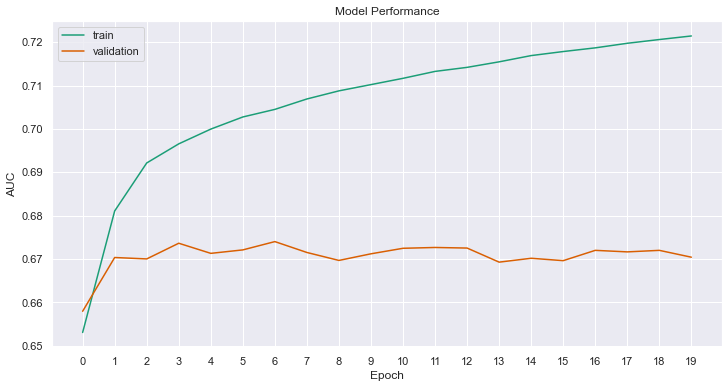

In [75]:
    plt.figure(figsize=(12,6))
    # plot results train and results test using sns
    sns.lineplot(x=range(len(results_train)), y=results_train, label='Train')
    sns.lineplot(x=range(len(results_test)), y=results_test, label='Test')
    plt.xticks(np.arange(0, len(results_test), step = 1))
    plt.title('Model Performance')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [77]:
neural_network_model, neural_network_auc, results_train, results_test = neural_network(df,6,cat_cols)

Epoch 1/6
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6551 - auc_1: 0.6543 - val_loss: 0.6568 - val_auc_1: 0.6600
Epoch 2/6
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6373 - auc_1: 0.6825 - val_loss: 0.6477 - val_auc_1: 0.6715
Epoch 3/6
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6307 - auc_1: 0.6922 - val_loss: 0.6536 - val_auc_1: 0.6716
Epoch 4/6
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6277 - auc_1: 0.6965 - val_loss: 0.6494 - val_auc_1: 0.6718
Epoch 5/6
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6255 - auc_1: 0.6997 - val_loss: 0.6491 - val_auc_1: 0.6704
Epoch 6/6
1608/1608 [==============================] - 3s 2ms/step - loss: 0.6233 - auc_1: 0.7030 - val_loss: 0.6561 - val_auc_1: 0.6711
ROC on test set: 0.6711284661335668


In [78]:
auc_dict = {"Catboost":catboost_auc,"Xgboost":xgb_auc,"Lightgbm":lightgbm_auc,"Neural_Network":neural_network_auc}
model_results = pd.DataFrame(auc_dict,index=["AUC"])
model_results.sort_values(by="AUC",ascending=False,inplace=True,axis=1)

In [81]:
model_results.transpose()

,AUC
Neural_Network,0.671128
Catboost,0.668311
Lightgbm,0.666698
Xgboost,0.650701


From the preliminary fitting of the the models we can see that our models performance is modest. With neural network having the highest AUC, followed closely by Catboost and LightGBM. Xgboost has the lowest AUC and thus the lowest performance.

### **4.4 Target encoding**

By utilizing the one hot encoding technique, we were able to use our categorical variables in our models. One downside of this technique is the addition of a column for every unique value of the categorical variable. For example if a variable has 3 unique values, then the new columns will be named as color_1, color_2 and color_3. This leads to an increase in model complexity due to the added sparseness of the data. Furthermore one-hot encoding is not suitable in handling categorical variables with a large number of unique values as converting these values to binary vectors can be computationally expensive and it also exacerbate the problem of **sparse data**. Therefore we will use **"target encoding"** to encode the categorical variables. This is a technique that calculates the mean response of the target variable for every column and its unique values. The upside of this technique is that it is a simple technique to handle categorical variables and it does not add any new columns to the dataset as opposed to **one-hot encoding**. The downside is that it is prone to **target leakage** and **overfitting** and thus needs to be slightly altered to prevent these issues.

Here is an example how to use **"target encoding"** to encode the categorical variable **size**.

In [82]:
example_target_encoding = df[["size","return"]].groupby("size")["return"].mean().reset_index()
example_target_encoding

,size,return
0,l,0.484930
1,m,0.504160
2,s,0.498293
3,unsized,0.410574
4,xl,0.466682
5,xs,0.497458
6,xxl,0.537371
7,xxxl,0.352067


After encoding the categorical variables we will perform a **left join** on **size** between the original dataframe and the dataframe containing the encoded classes and we will drop the original columns as its no longer needed. 

First we will demonstrate what target leakage and overfitting is by calculating the mean response variable on the **whole** dataset.

In [85]:
def get_return_ratio(df, columns):
    df_known = df.iloc[:k]
    for i in columns:
        df_total = round(df_known[[i,"return"]].groupby(i).mean(),4)
        df_total.rename(columns = {'return':i + '_return_rate'},inplace = True)
        df_known = pd.merge(df_known, df_total, on = i, how = "left")
        df_known.drop(i, axis = 1, inplace = True)
    return df_known

In [86]:
df_return = get_return_ratio(df,cat_cols)
# Reorder the columns
def reorder_columns(df_return):
    temp_cols = df_return.columns.tolist()
    len_cat_cols = len(cat_cols)
    new_cols = temp_cols[-len_cat_cols:] + temp_cols[:-len_cat_cols]
    df_return = df_return[new_cols]
    return df_return

df_return = reorder_columns(df_return)

In [88]:
df_return

,size_return_rate,item_color_return_rate,user_title_return_rate,user_state_return_rate,item_id_return_rate,brand_id_return_rate,user_id_return_rate,item_price,return,delivery_time,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,average_item_price_order,order_item_count,order_sum,order_number_same_item_id,order_number_different_item_id,order_number_same_size,order_number_different_size,order_number_same_item_color,order_number_different_item_color,order_number_same_brand_id,order_number_different_brand_id,order_number_same_item_id_size,order_number_different_item_id_size,order_number_same_item_id_item_color,order_number_different_item_id_item_color,order_number_same_size_item_color,order_number_different_size_item_color,order_number_same_size_brand_id,order_number_different_size_brand_id,order_number_same_item_color_brand_id,order_number_different_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_different_item_id_size_item_color,order_number_same_size_item_color_brand_id,order_number_different_size_item_color_brand_id
0,0.4983,0.5707,0.4854,0.4819,0.6431,0.6297,0.4545,69.90,0.0,2,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3
1,0.4106,0.5170,0.4854,0.4819,0.6100,0.5727,0.4545,69.95,1.0,2,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3
2,0.4106,0.5141,0.4854,0.4819,0.6100,0.5727,0.4545,69.95,1.0,2,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3
3,0.4983,0.4500,0.4854,0.5079,0.4470,0.5219,0.0000,39.90,0.0,4,52,89,0,4,4,4,2,6,14,14,39.90,1,39.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,0.4983,0.5012,0.4854,0.4897,0.5882,0.6113,0.1111,29.90,0.0,4,48,411,0,4,4,4,2,6,14,14,83.23,3,249.7,0,3,1,2,1,2,0,3,0,3,0,3,1,2,0,3,0,3,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481086,0.4983,0.4956,0.4101,0.4850,0.6613,0.5186,0.7627,139.90,1.0,9,50,750,6,1,3,4,31,9,13,15,139.90,2,279.8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
481087,0.4983,0.4956,0.4101,0.4850,0.6613,0.5186,0.7627,139.90,1.0,9,50,750,6,1,3,4,31,9,13,15,139.90,2,279.8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
481088,0.4983,0.5085,0.4854,0.4692,0.6162,0.5509,0.0000,130.00,0.0,2,48,372,6,1,3,4,31,2,13,14,130.00,1,130.0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
481089,0.4667,0.5012,0.4101,0.4692,0.6364,0.4623,0.0000,99.90,0.0,4,40,0,6,3,3,4,31,4,13,14,106.57,3,319.7,0,3,2,1,1,2,0,3,0,3,0,3,1,2,0,3,0,3,0,3,0,3


In [91]:
catboost_model,catboost_auc = catboost_classifier(df_return,[])

asd
Catboost AUC on test set: 0.7680148246050316


We can see that incorporating the target encoding technique improved the performance of the model by a large margin. Nonetheless, we can assume with utmost certainty that this model wont be able to generalize to new data, since the calculation of the target mean is done on the whole dataset, before a split has been made.

In [92]:
features = get_feature_importance(catboost_model,df_return)
features[:10]

[('user_id_return_rate', 68.09049162699301),
 ('delivery_time', 8.624914361058728),
 ('item_id_return_rate', 7.812798374410681),
 ('delivery_weekday', 4.615508212321823),
 ('order_number_same_item_id_item_color', 0.995535607721055),
 ('item_price', 0.9740848173143235),
 ('delivery_week', 0.7548947136119136),
 ('user_reg_age', 0.6964972476268051),
 ('order_number_different_size_item_color', 0.5662050857967179),
 ('order_number_different_size_item_color_brand_id', 0.46470363008984406)]

Judging by the feature importance **user_id_return_rate** is by far the most important feature followed by **item_id_return_rate** and both are most likely to be the cause of the target leakage.

In [95]:
df_return["user_id_return_rate"].value_counts()

0.0000    44242
0.5000    31228
1.0000    19384
0.6667    17637
0.3333    15912
          ...  
0.9259       27
0.9630       27
0.9200       25
0.9600       25
0.9545       22
Name: user_id_return_rate, Length: 948, dtype: int64

As we can see from the above output there are 44242 occurrences of items ordered by users who have never returned their items and 19384 who returned all their items. Thus the **user_id_return_rate** can be seen as a proxy for the target variable **return_rate** which in turn leads to the target leakage. To combat this we need to calculate the **mean** response** of the target variable for the training set and use the values for the test set since in real conditions it would be impossible to calculate the mean response of the target variable on new observations since we will not know the target values of these new observations.

In [96]:
# Define new way to calculate the return rate
def get_return_ratio(df, columns):
    # split the dataframe into train and test
    df_train,df_test = df.loc[:k][df.loc[:k,"order_month"] != 3],df.loc[:k][df.loc[:k,"order_month"] == 3]
    for i in columns:
        df_total = round(df_train[[i,"return"]].groupby(i).mean(),4)
        df_total.rename(columns = {'return':i + '_return_rate'},inplace = True)
        
        df_train = pd.merge(df_train, df_total, on = i, how = "left")
        df_test = pd.merge(df_test, df_total, on = i, how = "left")
        df_train.drop(i, axis = 1, inplace = True)
        df_test.drop(i, axis = 1, inplace = True)
    df_return = pd.concat([df_train,df_test])
    df_return.reset_index(drop=True,inplace=True)
    return df_return

In [97]:
df_return = get_return_ratio(df,cat_cols)
df_return = reorder_columns(df_return)
df_return

,size_return_rate,item_color_return_rate,user_title_return_rate,user_state_return_rate,item_id_return_rate,brand_id_return_rate,user_id_return_rate,order_item_id,item_price,return,delivery_time,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,average_item_price_order,order_item_count,order_sum,order_number_same_item_id,order_number_different_item_id,order_number_same_size,order_number_different_size,order_number_same_item_color,order_number_different_item_color,order_number_same_brand_id,order_number_different_brand_id,order_number_same_item_id_size,order_number_different_item_id_size,order_number_same_item_id_item_color,order_number_different_item_id_item_color,order_number_same_size_item_color,order_number_different_size_item_color,order_number_same_size_brand_id,order_number_different_size_brand_id,order_number_same_item_color_brand_id,order_number_different_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_different_item_id_size_item_color,order_number_same_size_item_color_brand_id,order_number_different_size_item_color_brand_id
0,0.4951,0.5647,0.4805,0.4775,0.6431,0.6302,0.4545,1,69.90,0.0,2,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3,0,3
1,0.4077,0.5132,0.4805,0.4775,0.6096,0.5727,0.4545,2,69.95,1.0,2,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3
2,0.4077,0.5068,0.4805,0.4775,0.6096,0.5727,0.4545,3,69.95,1.0,2,47,342,6,1,4,4,1,3,13,14,69.93,3,209.8,1,2,1,2,0,3,1,2,1,2,0,3,0,3,1,2,0,3,0,3,0,3
3,0.4951,0.4409,0.4805,0.5027,0.4472,0.5071,0.0000,4,39.90,0.0,4,52,89,0,4,4,4,2,6,14,14,39.90,1,39.9,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,0.4951,0.4983,0.4805,0.4828,0.5714,0.6107,0.0000,5,29.90,0.0,4,48,411,0,4,4,4,2,6,14,14,83.23,3,249.7,0,3,1,2,1,2,0,3,0,3,0,3,1,2,0,3,0,3,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481087,0.4951,0.4883,0.4112,0.4818,0.6849,0.5142,0.7544,481088,139.90,1.0,9,50,750,6,1,3,4,31,9,13,15,139.90,2,279.8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
481088,0.4951,0.5023,0.4805,0.4631,0.5957,0.5435,NaN,481089,130.00,0.0,2,48,372,6,1,3,4,31,2,13,14,130.00,1,130.0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
481089,0.4631,0.4983,0.4112,0.4631,0.6034,0.4522,NaN,481090,99.90,0.0,4,40,0,6,3,3,4,31,4,13,14,106.57,3,319.7,0,3,2,1,1,2,0,3,0,3,0,3,1,2,0,3,0,3,0,3,0,3
481090,0.4631,0.4983,0.4112,0.4631,0.7229,0.5800,NaN,481091,99.90,0.0,4,40,0,6,3,3,4,31,4,13,14,106.57,3,319.7,0,3,2,1,1,2,1,2,0,3,0,3,1,2,1,2,0,3,0,3,0,3


One downside of this approach is that unique values of the test set cannot be encoded, since we do not know their target values and they will be marked as NaNs. In order to fix this issue we will be replacing all NaNs with 0.5.

In [98]:
df_return.isnull().sum()

size_return_rate                                       0
item_color_return_rate                                 0
user_title_return_rate                                 0
user_state_return_rate                                 0
item_id_return_rate                                  161
brand_id_return_rate                                   0
user_id_return_rate                                31007
order_item_id                                          0
item_price                                             0
return                                                 0
delivery_time                                          0
user_age                                               0
user_reg_age                                           0
order_weekday                                          0
delivery_weekday                                       0
order_month                                            0
delivery_month                                         0
order_day                      

In [99]:
# # fill nan values with 0
df_return.fillna(0.5,inplace=True)

In [100]:
catboost_model,catboost_auc = catboost_classifier(df_return,[])

asd
Catboost AUC on test set: 0.6518091720492616


Now our model scored much worse than before, and even slightly worse than before incorporating the target encoding technique.

In [101]:
features = get_feature_importance(catboost_model,df_return)
features[:10]

[('user_id_return_rate', 68.60816965676854),
 ('item_id_return_rate', 7.905455905922881),
 ('delivery_time', 7.870829938059201),
 ('delivery_weekday', 4.911340244819731),
 ('order_item_id', 1.043224084180505),
 ('order_number_same_item_id_item_color', 1.0307733256410165),
 ('user_reg_age', 1.0037930637884804),
 ('order_item_count', 0.9421212479776278),
 ('item_price', 0.9144018247385474),
 ('order_number_different_item_id_size', 0.8614698926262521)]

We can see that the **user_id_return_rate** is still the most important feature and while this time it no longer cause target leakage, it still causes overfitting and thus lower performance on the test set. In the next step in order to combat the overfitting we will divide our data into **three sets**. The **first set** is going to be used for calculating the mean response of the target variable, the **second set** is going to be used for fitting the model and the **third** set is going to be used for evaluating the model.

<p align="center">
  <img src="time_window.png" />
</p>

In [120]:
# Compute the target response statistics for the first 8 months of the dataset train on the next 3 months and test on 1 month
def get_return_ratio(df, columns):
    # split the dataframe into train and test
    df_train = df.loc[:k][(df.loc[:k,"order_month"] > 3) & (df.loc[:k,"order_month"] < 12)]
    df_test  = df.loc[:k][(df.loc[:k,"order_month"] <= 3) | (df.loc[:k,"order_month"] == 12)]
    for i in columns:
        df_total = round(df_train[[i,"return"]].groupby(i).mean(),4)
        df_total.rename(columns = {'return':i + '_return_rate'},inplace = True)
        
        df_train = pd.merge(df_train, df_total, on = i, how = "left")
        df_test = pd.merge(df_test, df_total, on = i, how = "left")
        df_train.drop(i, axis = 1, inplace = True)
        df_test.drop(i, axis = 1, inplace = True)
    # df_return = pd.concat([df_train,df_test])
    df_return = df_test
    df_return.reset_index(drop=True,inplace=True)
    return df_return

In [121]:
df_return = get_return_ratio(df,cat_cols)
df_return = reorder_columns(df_return)


In [122]:
df_return

,size_return_rate,item_color_return_rate,user_title_return_rate,user_state_return_rate,item_id_return_rate,brand_id_return_rate,user_id_return_rate,order_item_id,item_price,return,delivery_time,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,average_item_price_order,order_item_count,order_sum,order_number_same_item_id,order_number_different_item_id,order_number_same_size,order_number_different_size,order_number_same_item_color,order_number_different_item_color,order_number_same_brand_id,order_number_different_brand_id,order_number_same_item_id_size,order_number_different_item_id_size,order_number_same_item_id_item_color,order_number_different_item_id_item_color,order_number_same_size_item_color,order_number_different_size_item_color,order_number_same_size_brand_id,order_number_different_size_brand_id,order_number_same_item_color_brand_id,order_number_different_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_different_item_id_size_item_color,order_number_same_size_item_color_brand_id,order_number_different_size_item_color_brand_id
0,0.4032,0.4921,0.4698,0.4542,0.5195,0.5819,0.6216,291577,90.00,1.0,2,43,654,5,0,12,12,1,3,48,49,90.00,2,180.00,1,1,1,1,0,2,1,1,1,1,0,2,0,2,1,1,0,2,0,2,0,2
1,0.4032,0.4895,0.4698,0.4542,0.5195,0.5819,0.6216,291578,90.00,0.0,4,43,654,5,2,12,12,1,5,48,49,90.00,2,180.00,1,1,1,1,0,2,1,1,1,1,0,2,0,2,1,1,0,2,0,2,0,2
2,0.4868,0.4921,0.4698,0.4660,0.4348,0.5164,NaN,291579,160.00,0.0,2,44,654,5,0,12,12,1,3,48,49,160.00,1,160.00,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
3,0.4862,0.4253,0.4698,0.4627,0.5760,0.4902,0.6154,291580,99.95,1.0,20,45,195,5,4,12,12,1,21,48,51,99.95,1,99.95,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
4,0.4868,0.4895,0.4698,0.4562,0.7873,0.5644,0.1364,291581,79.90,0.0,2,48,194,5,0,12,12,1,3,48,49,79.90,1,79.90,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189325,0.4862,0.4829,0.4158,0.4757,NaN,0.4998,0.7955,481088,139.90,1.0,9,50,750,6,1,3,4,31,9,13,15,139.90,2,279.80,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
189326,0.4862,0.4864,0.4698,0.4542,NaN,0.5164,NaN,481089,130.00,0.0,2,48,372,6,1,3,4,31,2,13,14,130.00,1,130.00,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
189327,0.4513,0.4895,0.4158,0.4542,NaN,0.4357,NaN,481090,99.90,0.0,4,40,0,6,3,3,4,31,4,13,14,106.57,3,319.70,0,3,2,1,1,2,0,3,0,3,0,3,1,2,0,3,0,3,0,3,0,3
189328,0.4513,0.4895,0.4158,0.4542,NaN,0.5561,NaN,481091,99.90,0.0,4,40,0,6,3,3,4,31,4,13,14,106.57,3,319.70,0,3,2,1,1,2,1,2,0,3,0,3,1,2,1,2,0,3,0,3,0,3


In [124]:
# fill nan values with 0
df_return.fillna(0.5,inplace=True)

In [125]:
catboost_model,catboost_auc = catboost_classifier(df_return,[])

asd
Catboost AUC on test set: 0.6583605224938915


In [127]:
features = get_feature_importance(catboost_model,df_return)
features[:10]

[('delivery_time', 14.059971844606249),
 ('user_id_return_rate', 12.694405826717118),
 ('delivery_weekday', 12.272535811869258),
 ('item_price', 8.924381250112175),
 ('order_sum', 5.379570048888265),
 ('brand_id_return_rate', 5.356136001738159),
 ('item_id_return_rate', 4.49295179891305),
 ('order_number_same_item_id_item_color', 3.432713598434904),
 ('user_reg_age', 2.572871345247567),
 ('user_age', 2.556155728450063)]

In [128]:
lightgbm_model,lightgbm_auc = lightgbm(df_return,[])

LGBM AUC on test set:  0.6624968054673447


In [129]:
features = get_feature_importance(lightgbm_model,df_return)
features

[('brand_id_return_rate', 228),
 ('user_id_return_rate', 228),
 ('item_price', 196),
 ('order_sum', 194),
 ('delivery_time', 172),
 ('item_id_return_rate', 169),
 ('average_item_price_order', 164),
 ('user_age', 154),
 ('user_reg_age', 150),
 ('order_item_id', 132),
 ('delivery_weekday', 124),
 ('delivery_day', 84),
 ('order_day', 71),
 ('item_color_return_rate', 70),
 ('size_return_rate', 65),
 ('user_state_return_rate', 64),
 ('order_number_same_item_id_item_color', 63),
 ('delivery_week', 60),
 ('order_number_same_size', 49),
 ('order_number_same_item_id', 44),
 ('order_number_same_brand_id', 44),
 ('order_weekday', 43),
 ('order_number_same_item_id_size', 41),
 ('order_item_count', 34),
 ('order_number_different_brand_id', 33),
 ('order_number_different_size', 30),
 ('order_number_same_size_brand_id', 29),
 ('order_number_different_size_brand_id', 29),
 ('order_number_different_item_color', 26),
 ('order_number_different_item_id_size', 24),
 ('order_number_different_item_id', 23),


In [132]:
neural_network_model, neural_network_auc, results_train, results_test = neural_network(df_return,5,[])

Epoch 1/5
468/468 [==============================] - 1s 2ms/step - loss: 0.6351 - auc_4: 0.6907 - val_loss: 0.6484 - val_auc_4: 0.6717
Epoch 2/5
468/468 [==============================] - 1s 2ms/step - loss: 0.6244 - auc_4: 0.7061 - val_loss: 0.6442 - val_auc_4: 0.6810
Epoch 3/5
468/468 [==============================] - 1s 2ms/step - loss: 0.6207 - auc_4: 0.7115 - val_loss: 0.6402 - val_auc_4: 0.6858
Epoch 4/5
468/468 [==============================] - 1s 2ms/step - loss: 0.6170 - auc_4: 0.7161 - val_loss: 0.6388 - val_auc_4: 0.6873
Epoch 5/5
468/468 [==============================] - 1s 2ms/step - loss: 0.6135 - auc_4: 0.7205 - val_loss: 0.6392 - val_auc_4: 0.6892
ROC on test set: 0.6891701208091736


In [137]:
xgb_model,xgb_auc = xgboost_classifier(df_return,[])

Xgboost AUC on test set: 0.6604209652754031


In [139]:
auc_dict_target = {"Catboost":catboost_auc,"Xgboost":xgb_auc,"Lightgbm":lightgbm_auc,"Neural_Network":neural_network_auc}
model_results_target = pd.DataFrame(auc_dict_target,index=["AUC_encoding"])
model_results_target.sort_values(by="AUC_encoding",ascending=False,inplace=True,axis=1)

In [140]:
model_results_target= model_results_target.transpose()
model_results_target

,AUC_encoding
Neural_Network,0.689170
Lightgbm,0.662497
Xgboost,0.660421
Catboost,0.658361


In [141]:
model_results_target_diff = model_results_target.join(model_results.transpose())
model_results_target_diff.rename(columns = {"AUC": "AUC_one_hot_native"},inplace=True)
model_results_target_diff["AUC_difference"] =  round(model_results_target_diff["AUC_encoding"] - model_results_target_diff["AUC_one_hot_native"],3)
model_results_target_diff

,AUC_encoding,AUC_one_hot_native,AUC_difference
Neural_Network,0.689170,0.671128,0.018
Lightgbm,0.662497,0.666698,-0.004
Xgboost,0.660421,0.650701,0.010
Catboost,0.658361,0.668311,-0.010


Overall we can see that models like **LightGBM** and **Catboost** who are able to handle categorical variables natively perform similarly only Catboost performs slightly worse. Xgboost perform better with the target encoding technique and now has similar performance to the other models. The neural network still performs better than the other models and gets a slightly better AUC score.

The negative aspect of using target encoding with three different sets is that we have a certain lag between calculating the mean response of the target variable and fitting the model. Another issue is that we have to use a considerable amount of data to calculate the mean response of the target variable which we cannot use in the training since it will lead to overfitting and thus can be considered lost.

### **4.5 Leave One Out Encoder TODO !!!!**

In [195]:
from category_encoders import LeaveOneOutEncoder

In [14]:
df_known = df.iloc[:k]
df_known

,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_state,return,delivery_time,order_id,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,order_item_count,order_sum,average_item_price_order,order_number_same_item_id,order_number_same_size,order_number_same_item_color,order_number_same_brand_id,order_number_same_item_id_size,order_number_same_item_id_item_color,order_number_same_size_item_color,order_number_same_size_brand_id,order_number_same_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_same_size_item_color_brand_id
0,643,xs,navy,30,49.90,30822,Mrs,Saxony,0.0,5,2016-06-22_30822,47,0,2,0,6,6,22,27,25,26,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0
1,337,xxxl,grey,30,19.95,30822,Mrs,Saxony,0.0,3,2016-06-22_30822,47,0,2,5,6,6,22,25,25,25,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0
2,270,xl,grey,49,79.90,30823,Mrs,Bad-Wue,1.0,5,2016-06-22_30823,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1
3,142,xl,grey,49,99.90,30823,Mrs,Bad-Wue,0.0,5,2016-06-22_30823,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1
4,561,xl,grey,3,14.90,30823,Mrs,Bad-Wue,1.0,5,2016-06-22_30823,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,156,unsized,blue,34,29.90,713,Mrs,Rhine-Pal,0.0,1,2016-09-11_713,57,572,6,0,9,9,11,12,36,37,2,59.80,29.900000,1,1,0,1,1,0,0,1,0,0,0
99996,156,unsized,brown,34,29.90,713,Mrs,Rhine-Pal,0.0,1,2016-09-11_713,57,572,6,0,9,9,11,12,36,37,2,59.80,29.900000,1,1,0,1,1,0,0,1,0,0,0
99997,1832,xl,black,37,26.90,47794,Mr,Hamburg,0.0,3,2016-09-11_47794,32,1,6,2,9,9,11,14,36,37,2,53.80,26.900000,1,1,1,1,1,1,1,1,1,1,1
99998,1832,xl,black,37,26.90,47794,Mr,Hamburg,0.0,3,2016-09-11_47794,32,1,6,2,9,9,11,14,36,37,2,53.80,26.900000,1,1,1,1,1,1,1,1,1,1,1


In [332]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1,len(s)+1))
categorical_powerset = powerset(cat_cols)

In [333]:
# Use the powerset to create new columns indicating the amount of same items in the order
powerset_name_list = []
# exclude powerset elements containing both item_id and brand_id
exclude = ["item_id","brand_id"]
for column in categorical_powerset:
    current = list(column)
    if not all(x in current for x in exclude) and len(current) > 1 and len(current) < 3:
        print(current)
        column_name = ""
        df_known[current] = df_known[current].astype(str)
        # sum the strings in the column
        for i in current:
            column_name += i + "_"
        powerset_name_list.append(column_name)
        df_known[column_name] = df_known[current].sum(axis=1).astype('category').cat.codes
        

['size', 'item_color']
['size', 'user_title']
['size', 'user_state']
['size', 'item_id']
['size', 'brand_id']
['size', 'user_id']
['item_color', 'user_title']
['item_color', 'user_state']
['item_color', 'item_id']
['item_color', 'brand_id']
['item_color', 'user_id']
['user_title', 'user_state']
['user_title', 'item_id']
['user_title', 'brand_id']
['user_title', 'user_id']
['user_state', 'item_id']
['user_state', 'brand_id']
['user_state', 'user_id']
['item_id', 'user_id']
['brand_id', 'user_id']


In [334]:
df_known

,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_state,return,delivery_time,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,order_item_count,order_sum,average_item_price_order,order_number_same_item_id,order_number_same_size,order_number_same_item_color,order_number_same_brand_id,order_number_same_item_id_size,order_number_same_item_id_item_color,order_number_same_size_item_color,order_number_same_size_brand_id,order_number_same_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_same_size_item_color_brand_id,size_item_color_,size_user_title_,size_user_state_,size_item_id_,size_brand_id_,size_user_id_,item_color_user_title_,item_color_user_state_,item_color_item_id_,item_color_brand_id_,item_color_user_id_,user_title_user_state_,user_title_item_id_,user_title_brand_id_,user_title_user_id_,user_state_item_id_,user_state_brand_id_,user_state_user_id_,item_id_user_id_,brand_id_user_id_
0,643,xs,navy,30,49.90,30822,Mrs,Saxony,0.0,5,47,0,2,0,6,6,22,27,25,26,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0,369,28,93,5459,424,33738,164,726,3617,705,43735,51,2952,275,6718,15013,1487,18512,42415,36293
1,337,xxxl,grey,30,19.95,30822,Mrs,Saxony,0.0,3,47,0,2,5,6,6,22,25,25,25,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0,422,36,125,5790,505,38112,128,547,3162,562,36523,51,2643,275,6718,14846,1487,18512,34684,36293
2,270,xl,grey,49,79.90,30823,Mrs,Bad-Wue,1.0,5,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1,291,23,64,4332,376,30188,128,534,3138,580,36524,38,2575,295,6719,898,66,652,32090,50312
3,142,xl,grey,49,99.90,30823,Mrs,Bad-Wue,0.0,5,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1,291,23,64,4039,376,30188,128,534,2927,580,36524,38,1639,295,6719,161,66,652,18135,50312
4,561,xl,grey,3,14.90,30823,Mrs,Bad-Wue,1.0,5,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1,291,23,64,4425,361,30188,128,534,3222,561,36524,38,2871,274,6719,1136,45,652,40834,11463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,156,unsized,blue,34,29.90,713,Mrs,Rhine-Pal,0.0,1,57,572,6,0,9,9,11,12,36,37,2,59.80,29.900000,1,1,0,1,1,0,0,1,0,0,0,217,18,58,3379,285,28638,58,243,1430,257,21942,48,1789,279,18415,11226,1109,16810,573,1568
99996,156,unsized,brown,34,29.90,713,Mrs,Rhine-Pal,0.0,1,57,572,6,0,9,9,11,12,36,37,2,59.80,29.900000,1,1,0,1,1,0,0,1,0,0,0,219,18,58,3379,285,28638,67,275,1981,353,27925,48,1789,279,18415,11226,1109,16810,573,1568
99997,1832,xl,black,37,26.90,47794,Mr,Hamburg,0.0,3,32,1,6,2,9,9,11,14,36,37,2,53.80,26.900000,1,1,1,1,1,1,1,1,1,1,1,273,22,69,4207,368,31999,49,206,829,178,15209,27,756,162,1076,5535,559,6726,70878,41524
99998,1832,xl,black,37,26.90,47794,Mr,Hamburg,0.0,3,32,1,6,2,9,9,11,14,36,37,2,53.80,26.900000,1,1,1,1,1,1,1,1,1,1,1,273,22,69,4207,368,31999,49,206,829,178,15209,27,756,162,1076,5535,559,6726,70878,41524


In [335]:
# df.drop(["return"],axis=1).columns
def encode_categorical_columns(df,columns,sig):
    encoder = LeaveOneOutEncoder(cols=columns, return_df=True,sigma=sig, verbose=True)
    df_encode_train = encoder.fit_transform(df_known[:80000].drop(["return"],axis=1),df_known[:80000][["return"]])
    df_encode_test = encoder.transform(df_known[80000:].drop(["return"],axis=1))
    df_encode = pd.concat([df_encode_train,df_encode_test])
    df_encode["return"] = df_known["return"].astype(int)
    return df_encode

In [336]:
df_encode_train

,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_state,delivery_time,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,order_item_count,order_sum,average_item_price_order,order_number_same_item_id,order_number_same_size,order_number_same_item_color,order_number_same_brand_id,order_number_same_item_id_size,order_number_same_item_id_item_color,order_number_same_size_item_color,order_number_same_size_brand_id,order_number_same_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_same_size_item_color_brand_id
0,0.145674,0.586570,0.439498,0.553816,49.90,0.000000,0.446277,0.607050,5,47,0,2,0,6,6,22,27,25,26,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0
1,0.159865,0.536741,-0.042974,0.225404,19.95,0.000000,0.293428,0.443489,3,47,0,2,5,6,6,22,25,25,25,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0
2,0.993605,-0.219562,0.650816,0.157206,79.90,0.930775,-0.070872,0.364667,5,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1
3,0.551762,0.499696,0.521202,0.131901,99.90,0.511846,0.762715,0.866687,5,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1
4,0.504953,0.317230,0.840855,0.030272,14.90,0.746144,0.612829,0.088965,5,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.087903,0.674656,0.230173,0.609797,19.90,1.567434,0.699576,0.028194,3,64,554,2,5,8,8,24,27,34,34,2,49.80,24.900000,0,1,0,0,0,0,0,0,0,0,0
79996,0.679568,0.322259,0.339529,0.278070,49.90,0.260656,0.409617,0.674619,4,36,554,2,6,8,8,24,28,34,34,4,239.70,59.925000,0,2,0,0,0,0,0,0,0,0,0
79997,0.439501,0.242394,0.440678,0.718038,29.90,0.356453,0.800098,0.350985,4,36,554,2,6,8,8,24,28,34,34,4,239.70,59.925000,1,2,0,1,1,0,0,1,0,0,0
79998,0.291918,0.460939,0.753857,0.977644,130.00,0.000000,0.879040,0.476755,7,36,554,2,2,8,8,24,31,34,35,4,239.70,59.925000,0,0,0,0,0,0,0,0,0,0,0


In [265]:
df_encode = pd.concat([df_encode_train,df_encode_test])
df_encode["return"] = df_known["return"].astype(int)
df_encode

,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_state,delivery_time,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,order_item_count,order_sum,average_item_price_order,order_number_same_item_id,order_number_same_size,order_number_same_item_color,order_number_same_brand_id,order_number_same_item_id_size,order_number_same_item_id_item_color,order_number_same_size_item_color,order_number_same_size_brand_id,order_number_same_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_same_size_item_color_brand_id,return
0,0.163809,0.484632,0.310860,0.292159,49.90,0.000000,0.461382,0.443357,5,47,0,2,0,6,6,22,27,25,26,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0,0
1,0.105225,0.349722,0.469668,0.339422,19.95,0.000000,0.450445,0.507012,3,47,0,2,5,6,6,22,25,25,25,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0,0
2,0.506970,0.322487,0.457480,0.526101,79.90,0.531215,0.440837,0.401275,5,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1,1
3,0.470805,0.467951,0.500477,0.516931,99.90,0.649966,0.353108,0.478424,5,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1,0
4,0.366401,0.471350,0.546659,0.394752,14.90,0.637380,0.449669,0.480130,5,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.485000,0.404145,0.460405,0.492447,29.90,1.000000,0.454249,0.449320,1,57,572,6,0,9,9,11,12,36,37,2,59.80,29.900000,1,1,0,1,1,0,0,1,0,0,0,0
99996,0.485000,0.404145,0.481066,0.492447,29.90,1.000000,0.454249,0.449320,1,57,572,6,0,9,9,11,12,36,37,2,59.80,29.900000,1,1,0,1,1,0,0,1,0,0,0,0
99997,0.446154,0.433419,0.460799,0.444980,26.90,0.452612,0.411590,0.423737,3,32,1,6,2,9,9,11,14,36,37,2,53.80,26.900000,1,1,1,1,1,1,1,1,1,1,1,0
99998,0.446154,0.433419,0.460799,0.444980,26.90,0.452612,0.411590,0.423737,3,32,1,6,2,9,9,11,14,36,37,2,53.80,26.900000,1,1,1,1,1,1,1,1,1,1,1,0


In [337]:
df_encode

,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_state,delivery_time,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,order_item_count,order_sum,average_item_price_order,order_number_same_item_id,order_number_same_size,order_number_same_item_color,order_number_same_brand_id,order_number_same_item_id_size,order_number_same_item_id_item_color,order_number_same_size_item_color,order_number_same_size_brand_id,order_number_same_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_same_size_item_color_brand_id,size_item_color_,size_user_title_,size_user_state_,size_item_id_,size_brand_id_,size_user_id_,item_color_user_title_,item_color_user_state_,item_color_item_id_,item_color_brand_id_,item_color_user_id_,user_title_user_state_,user_title_item_id_,user_title_brand_id_,user_title_user_id_,user_state_item_id_,user_state_brand_id_,user_state_user_id_,item_id_user_id_,brand_id_user_id_,size_item_color_user_title_,size_item_color_user_state_,size_item_color_item_id_,size_item_color_brand_id_,size_item_color_user_id_,size_user_title_user_state_,size_user_title_item_id_,size_user_title_brand_id_,size_user_title_user_id_,size_user_state_item_id_,size_user_state_brand_id_,size_user_state_user_id_,size_item_id_user_id_,size_brand_id_user_id_,item_color_user_title_user_state_,item_color_user_title_item_id_,item_color_user_title_brand_id_,item_color_user_title_user_id_,item_color_user_state_item_id_,item_color_user_state_brand_id_,item_color_user_state_user_id_,item_color_item_id_user_id_,item_color_brand_id_user_id_,user_title_user_state_item_id_,user_title_user_state_brand_id_,user_title_user_state_user_id_,user_title_item_id_user_id_,user_title_brand_id_user_id_,user_state_item_id_user_id_,user_state_brand_id_user_id_,size_item_color_user_title_user_state_,size_item_color_user_title_item_id_,size_item_color_user_title_brand_id_,size_item_color_user_title_user_id_,size_item_color_user_state_item_id_,size_item_color_user_state_brand_id_,size_item_color_user_state_user_id_,size_item_color_item_id_user_id_,size_item_color_brand_id_user_id_,size_user_title_user_state_item_id_,size_user_title_user_state_brand_id_,size_user_title_user_state_user_id_,size_user_title_item_id_user_id_,size_user_title_brand_id_user_id_,size_user_state_item_id_user_id_,size_user_state_brand_id_user_id_,item_color_user_title_user_state_item_id_,item_color_user_title_user_state_brand_id_,item_color_user_title_user_state_user_id_,item_color_user_title_item_id_user_id_,item_color_user_title_brand_id_user_id_,item_color_user_state_item_id_user_id_,item_color_user_state_brand_id_user_id_,user_title_user_state_item_id_user_id_,user_title_user_state_brand_id_user_id_,size_item_color_user_title_user_state_item_id_,size_item_color_user_title_user_state_brand_id_,size_item_color_user_title_user_state_user_id_,size_item_color_user_title_item_id_user_id_,size_item_color_user_title_brand_id_user_id_,size_item_color_user_state_item_id_user_id_,size_item_color_user_state_brand_id_user_id_,size_user_title_user_state_item_id_user_id_,size_user_title_user_state_brand_id_user_id_,item_color_user_title_user_state_item_id_user_id_,item_color_user_title_user_state_brand_id_user_id_,size_item_color_user_title_user_state_item_id_user_id_,size_item_color_user_title_user_state_brand_id_user_id_,return
0,0.165218,0.505187,0.273355,0.321405,49.90,0.000000,0.415584,0.480863,5,47,0,2,0,6,6,22,27,25,26,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0,0.287423,0.454886,0.346626,0.000000,0.294825,0.472084,0.252311,0.331084,0.000000,0.191401,0.000000,0.513510,0.155306,0.322603,0.000000,0.439094,0.332300,0.000000,0.566000,0.000000,0.329946,1.019125,0.000000,0.268240,0.502543,0.487688,0.000000,0.275619,0.415261,0.450032,0.993568,0.400941,0.456567,0.437176,0.379314,0.000000,0.206615,0.000000,0.489292,0.324605,0.000000,0.454316,0.000000,0.386333,0.401155,0.000000,0.471063,0.000000,0.435687,0.0000

In [340]:
neural_network_model, neural_network_auc, results_train, results_test = neural_network(df_encode,4,[],0.8)

Epoch 1/4
313/313 [==============================] - 1s 3ms/step - loss: 0.5975 - auc_27: 0.7378 - val_loss: 0.6608 - val_auc_27: 0.6685
Epoch 2/4
313/313 [==============================] - 1s 2ms/step - loss: 0.5809 - auc_27: 0.7574 - val_loss: 0.6598 - val_auc_27: 0.6734
Epoch 3/4
313/313 [==============================] - 1s 2ms/step - loss: 0.5752 - auc_27: 0.7634 - val_loss: 0.6683 - val_auc_27: 0.6714
Epoch 4/4
313/313 [==============================] - 1s 2ms/step - loss: 0.5716 - auc_27: 0.7674 - val_loss: 0.6735 - val_auc_27: 0.6648
ROC on test set: 0.6648824940056608


In [261]:
xgb_model,xgb_auc = xgboost_classifier(df_encode,[],0.8)

[0]	validation_0-auc:0.64280
[1]	validation_0-auc:0.65377
[2]	validation_0-auc:0.65984
[3]	validation_0-auc:0.66491
[4]	validation_0-auc:0.67098
[5]	validation_0-auc:0.67195
[6]	validation_0-auc:0.67585
[7]	validation_0-auc:0.67925
[8]	validation_0-auc:0.68005
[9]	validation_0-auc:0.67990
[10]	validation_0-auc:0.68072
[11]	validation_0-auc:0.68165
[12]	validation_0-auc:0.68223
[13]	validation_0-auc:0.68322
[14]	validation_0-auc:0.68510
[15]	validation_0-auc:0.68598
[16]	validation_0-auc:0.68654
[17]	validation_0-auc:0.68724
[18]	validation_0-auc:0.68837
[19]	validation_0-auc:0.68870
[20]	validation_0-auc:0.68925
[21]	validation_0-auc:0.68958
[22]	validation_0-auc:0.69015
[23]	validation_0-auc:0.69054
[24]	validation_0-auc:0.69073
[25]	validation_0-auc:0.69139
[26]	validation_0-auc:0.69230
[27]	validation_0-auc:0.69258
[28]	validation_0-auc:0.69261
[29]	validation_0-auc:0.69332
[30]	validation_0-auc:0.69352
[31]	validation_0-auc:0.69411
[32]	validation_0-auc:0.69437
[33]	validation_0-au

In [262]:
features = get_feature_importance(xgb_model,df_encode)
features

[('user_id', 0.16284661),
 ('item_id', 0.092242114),
 ('order_weekday', 0.07580764),
 ('order_item_count', 0.046272423),
 ('delivery_time', 0.04475993),
 ('order_number_same_item_id_item_color', 0.037435092),
 ('order_sum', 0.036493286),
 ('order_number_same_item_id', 0.030953594),
 ('order_week', 0.027753543),
 ('order_number_same_item_id_size_item_color', 0.026114257),
 ('order_number_same_item_color_brand_id', 0.02528038),
 ('item_price', 0.025200404),
 ('order_number_same_brand_id', 0.024158537),
 ('delivery_weekday', 0.02359018),
 ('order_number_same_size', 0.023034794),
 ('order_number_same_item_id_size', 0.022950815),
 ('delivery_week', 0.021062544),
 ('delivery_month', 0.02007351),
 ('delivery_day', 0.01980214),
 ('order_day', 0.018453376),
 ('order_number_same_size_brand_id', 0.017953793),
 ('order_month', 0.017863447),
 ('brand_id', 0.017844653),
 ('order_number_same_size_item_color_brand_id', 0.01737516),
 ('average_item_price_order', 0.01715095),
 ('user_reg_age', 0.0161678

In [338]:
df_encode = encode_categorical_columns(df_known,cat_cols + powerset_name_list,0.1)
df_encode

,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_state,delivery_time,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,order_item_count,order_sum,average_item_price_order,order_number_same_item_id,order_number_same_size,order_number_same_item_color,order_number_same_brand_id,order_number_same_item_id_size,order_number_same_item_id_item_color,order_number_same_size_item_color,order_number_same_size_brand_id,order_number_same_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_same_size_item_color_brand_id,size_item_color_,size_user_title_,size_user_state_,size_item_id_,size_brand_id_,size_user_id_,item_color_user_title_,item_color_user_state_,item_color_item_id_,item_color_brand_id_,item_color_user_id_,user_title_user_state_,user_title_item_id_,user_title_brand_id_,user_title_user_id_,user_state_item_id_,user_state_brand_id_,user_state_user_id_,item_id_user_id_,brand_id_user_id_,return
0,0.173891,0.462051,0.248207,0.309272,49.90,0.000000,0.469347,0.459366,5,47,0,2,0,6,6,22,27,25,26,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0,0.309650,0.496109,0.435530,0.000000,0.273418,0.482214,0.260055,0.352181,0.000000,0.195538,0.000000,0.516511,0.199489,0.329044,0.000000,0.438152,0.345107,0.000000,0.503697,0.000000,0
1,0.103458,0.370474,0.499658,0.256314,19.95,0.000000,0.501356,0.536926,3,47,0,2,5,6,6,22,25,25,25,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0,0.263680,0.309905,0.172618,0.096172,0.175301,0.448841,0.486055,0.510440,0.272078,0.217109,0.375593,0.459719,0.104269,0.382513,0.000000,0.469550,0.427530,0.000000,0.398044,0.000000,0
2,0.480257,0.423362,0.507471,0.552374,79.90,0.494662,0.399886,0.553694,5,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1,0.418713,0.420612,0.376577,0.421766,0.566156,0.575338,0.495285,0.387724,0.191177,0.478984,0.532327,0.483398,0.589493,0.532735,0.596304,0.406290,0.424479,0.502268,0.403322,0.000000,1
3,0.625563,0.420920,0.398735,0.556378,99.90,0.662986,0.450081,0.462527,5,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1,0.471819,0.496574,0.348932,0.455588,0.566850,0.702749,0.355995,0.536281,0.482410,0.384932,0.678364,0.449736,0.525443,0.543216,0.638818,0.579473,0.524221,0.682988,0.481080,1.068629,0
4,0.400782,0.431656,0.415901,0.373304,14.90,0.587121,0.491459,0.323341,5,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1,0.352861,0.502324,0.524837,0.342437,0.266463,0.533482,0.442215,0.509706,0.437233,0.428731,0.496175,0.414674,0.410038,0.357743,0.554062,0.181388,0.338239,0.559391,0.415554,0.856391,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.485000,0.404145,0.460405,0.492447,29.90,1.000000,0.454249,0.449320,1,57,572,6,0,9,9,11,12,36,37,2,59.80,29.900000,1,1,0,1,1,0,0,1,0,0,0,0.430627,0.404531,0.374545,0.410526,0.494444,1.000000,0.461694,0.463869,0.583333,0.517647,0.452612,0.447996,0.487310,0.498447,1.000000,0.454545,0.516129,1.000000,1.000000,1.000000,0
99996,0.485000,0.404145,0.481066,0.492447,29.90,1.000000,0.454249,0.449320,1,57,572,6,0,9,9,11,12,36,37,2,59.80,29.900000,1,1,0,1,1,0,0,1,0,0,0,0.447178,0.404531,0.374545,0.410526,0.494444,1.000000,0.484896,0.510264,0.777778,0.777778,0.452612,0.447996,0.487310,0.498447,1.000000,0.454545,0.516129,1.000000,1.000000,1.000000,0
99997,0.446154,0.433419,0.460799,0.444980,26.90,0.452612,0.411590,0.423737,3,32,1,6,2,9,9,11,14,36,37,2,53.80,26.900000,1,1,1,1,1,1,1,1,1,1,1,0.438822,0.385027,0.375587,0.357143,0.420440,0.452612,0.408027,0.422604,0.333333,0.414085,0.452612,0.289855,0.285714,0.410959,0.452612,0.750000,0.323529,0.452612,0.452612,0.452612,0
99998,0.446154,0.433419,0.460799,0.444980,26.90,0.452612,0.411590,0.423737,3,32,1,6,2,9,9,11,14,36,37,2,53.80,26.900000,1,1,1,1,1,1,1,1,1,1,1,0.438822,0.385027,0.375587,0.35714

In [339]:
xgb_model,xgb_auc = xgboost_classifier(df_encode,[],0.8)

[0]	validation_0-auc:0.65192
[1]	validation_0-auc:0.66139
[2]	validation_0-auc:0.66490
[3]	validation_0-auc:0.66859
[4]	validation_0-auc:0.67086
[5]	validation_0-auc:0.67130
[6]	validation_0-auc:0.67200
[7]	validation_0-auc:0.67353
[8]	validation_0-auc:0.67564
[9]	validation_0-auc:0.67740
[10]	validation_0-auc:0.67911
[11]	validation_0-auc:0.68022
[12]	validation_0-auc:0.68144
[13]	validation_0-auc:0.68238
[14]	validation_0-auc:0.68433
[15]	validation_0-auc:0.68510
[16]	validation_0-auc:0.68586
[17]	validation_0-auc:0.68717
[18]	validation_0-auc:0.68795
[19]	validation_0-auc:0.68866
[20]	validation_0-auc:0.68994
[21]	validation_0-auc:0.69051
[22]	validation_0-auc:0.69113
[23]	validation_0-auc:0.69117
[24]	validation_0-auc:0.69143
[25]	validation_0-auc:0.69153
[26]	validation_0-auc:0.69173
[27]	validation_0-auc:0.69181
[28]	validation_0-auc:0.69209
[29]	validation_0-auc:0.69222
[30]	validation_0-auc:0.69281
[31]	validation_0-auc:0.69304
[32]	validation_0-auc:0.69354
[33]	validation_0-au

In [328]:
features = get_feature_importance(xgb_model,df_encode)
features

[('user_state_user_id_', 0.11137445),
 ('user_title_user_state_user_id_', 0.047706936),
 ('user_title_user_id_', 0.04390736),
 ('user_id', 0.033064146),
 ('order_weekday', 0.029007737),
 ('item_id', 0.027649086),
 ('user_title_item_id_', 0.021917576),
 ('item_color_item_id_', 0.021295492),
 ('size_item_id_', 0.02039193),
 ('order_item_count', 0.015736373),
 ('order_number_same_item_id', 0.014124409),
 ('delivery_time', 0.014001438),
 ('size_user_state_user_id_', 0.011994808),
 ('order_sum', 0.011828808),
 ('item_color_user_title_item_id_', 0.011482364),
 ('size_user_title_brand_id_user_id_', 0.009986473),
 ('item_price', 0.009826468),
 ('size_user_title_user_state_brand_id_user_id_', 0.009790588),
 ('order_number_same_item_id_item_color', 0.0097589195),
 ('size_brand_id_user_id_', 0.009702452),
 ('order_week', 0.009590637),
 ('size_item_color_item_id_', 0.0095631955),
 ('order_number_same_brand_id', 0.009399663),
 ('size_user_title_item_id_', 0.009341796),
 ('size_user_title_item_id_us

In [13]:
df.iloc[:k]

,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_state,return,delivery_time,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,order_item_count,order_sum,average_item_price_order,order_number_same_item_id,order_number_same_size,order_number_same_item_color,order_number_same_brand_id,order_number_same_item_id_size,order_number_same_item_id_item_color,order_number_same_size_item_color,order_number_same_size_brand_id,order_number_same_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_same_size_item_color_brand_id
0,643,xs,navy,30,49.90,30822,Mrs,Saxony,0.0,5,47,0,2,0,6,6,22,27,25,26,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0
1,337,xxxl,grey,30,19.95,30822,Mrs,Saxony,0.0,3,47,0,2,5,6,6,22,25,25,25,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0
2,270,xl,grey,49,79.90,30823,Mrs,Bad-Wue,1.0,5,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1
3,142,xl,grey,49,99.90,30823,Mrs,Bad-Wue,0.0,5,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1
4,561,xl,grey,3,14.90,30823,Mrs,Bad-Wue,1.0,5,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,156,unsized,blue,34,29.90,713,Mrs,Rhine-Pal,0.0,1,57,572,6,0,9,9,11,12,36,37,2,59.80,29.900000,1,1,0,1,1,0,0,1,0,0,0
99996,156,unsized,brown,34,29.90,713,Mrs,Rhine-Pal,0.0,1,57,572,6,0,9,9,11,12,36,37,2,59.80,29.900000,1,1,0,1,1,0,0,1,0,0,0
99997,1832,xl,black,37,26.90,47794,Mr,Hamburg,0.0,3,32,1,6,2,9,9,11,14,36,37,2,53.80,26.900000,1,1,1,1,1,1,1,1,1,1,1
99998,1832,xl,black,37,26.90,47794,Mr,Hamburg,0.0,3,32,1,6,2,9,9,11,14,36,37,2,53.80,26.900000,1,1,1,1,1,1,1,1,1,1,1


In [14]:
test = df.iloc[:k]

In [141]:
neural_network_model, neural_network_auc, results_train, results_test = neural_network(test[["log_item_price","return","item_price"]],7,[],0.8)

Epoch 1/7
313/313 [==============================] - 1s 3ms/step - loss: 0.6750 - auc_48: 0.5885 - val_loss: 0.6776 - val_auc_48: 0.6004
Epoch 2/7
313/313 [==============================] - 1s 2ms/step - loss: 0.6740 - auc_48: 0.5912 - val_loss: 0.6763 - val_auc_48: 0.6006
Epoch 3/7
313/313 [==============================] - 1s 2ms/step - loss: 0.6739 - auc_48: 0.5915 - val_loss: 0.6775 - val_auc_48: 0.6006
Epoch 4/7
313/313 [==============================] - 1s 2ms/step - loss: 0.6738 - auc_48: 0.5918 - val_loss: 0.6779 - val_auc_48: 0.6004
Epoch 5/7
313/313 [==============================] - 1s 2ms/step - loss: 0.6739 - auc_48: 0.5910 - val_loss: 0.6769 - val_auc_48: 0.6006
Epoch 6/7
313/313 [==============================] - 1s 2ms/step - loss: 0.6738 - auc_48: 0.5917 - val_loss: 0.6767 - val_auc_48: 0.5998
Epoch 7/7
313/313 [==============================] - 1s 2ms/step - loss: 0.6738 - auc_48: 0.5920 - val_loss: 0.6774 - val_auc_48: 0.5994
ROC on test set: 0.5987967464539462


In [72]:
# ANOVA feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
fs = SelectKBest(score_func=f_classif, k=1)
# apply feature selection
X_selected = fs.fit_transform(df_known.drop(["return"],axis=1),df_known["return"])

X_selected

TypeError: can only concatenate str (not "list") to str

In [137]:
# Get columns to keep and create new dataframe with those only
cols = fs.get_support(indices=True)
features_df_new = test.iloc[:,cols]
features_df_new["return"] = test["return"]
features_df_new

,order_number_same_size_item_color_brand_id,return
0,0,0.0
1,0,0.0
2,1,1.0
3,1,0.0
4,1,1.0
...,...,...
99995,0,0.0
99996,0,0.0
99997,1,0.0
99998,1,0.0


In [138]:
fs.scores_

array([2.00160548e+03, 1.86836238e+01, 1.99246963e+02, 1.08147566e+02,
       1.51268201e+01, 4.74465940e-01, 3.44852635e+02, 2.77235243e+02,
       7.95833236e+00, 4.35802832e+01, 4.10213901e+02, 3.85750333e+02,
       6.58704980e+02, 1.75707622e+03, 1.44442793e+03, 6.20182704e+01,
       3.53887488e+02, 6.50647734e+02, 8.65209117e+01, 6.31895191e+01,
       6.82540840e+02, 2.20220490e+02, 2.13827776e-01, 6.44354873e+02,
       1.41988531e+00, 5.18622730e+01, 3.00584265e+03])

Ideas for features engineering:
1. number of orders per user bad
2. number of items bought per user
3. days since last order per user
4. total revenue per user
5. difference between avg item price per order and item price
6. difference between the price of same item id that has been bought by the same customer in two consecutive orders

In [44]:
# get number of orders for each user
df_total = df_known[["user_id","order_id"]].drop_duplicates()
df_total = df_total.groupby("user_id").count()
df_total.rename(columns={"order_id":"total_orders_per_user"},inplace=True)
df_known = df_known.merge(df_total,on="user_id")
df_known

,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_state,return,delivery_time,order_id,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,order_item_count,order_sum,average_item_price_order,order_number_same_item_id,order_number_same_size,order_number_same_item_color,order_number_same_brand_id,order_number_same_item_id_size,order_number_same_item_id_item_color,order_number_same_size_item_color,order_number_same_size_brand_id,order_number_same_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_same_size_item_color_brand_id,total_orders_per_user
0,643,xs,navy,30,49.90,30822,Mrs,Saxony,0.0,5,2016-06-22_30822,47,0,2,0,6,6,22,27,25,26,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0,2
1,337,xxxl,grey,30,19.95,30822,Mrs,Saxony,0.0,3,2016-06-22_30822,47,0,2,5,6,6,22,25,25,25,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0,2
2,53,unsized,navy,30,16.40,30822,Mrs,Saxony,0.0,7,2016-06-29_30822,47,6,2,2,6,7,29,6,26,27,1,16.40,16.400000,0,0,0,0,0,0,0,0,0,0,0,2
3,270,xl,grey,49,79.90,30823,Mrs,Bad-Wue,1.0,5,2016-06-22_30823,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1,2
4,142,xl,grey,49,99.90,30823,Mrs,Bad-Wue,0.0,5,2016-06-22_30823,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1530,m,black,56,79.90,12130,Mrs,Low-Saxony,0.0,1,2016-09-11_12130,52,235,6,0,9,9,11,12,36,37,7,516.35,73.764286,0,2,0,0,0,0,0,0,0,0,0,1
99996,1668,unsized,purple,32,79.90,12130,Mrs,Low-Saxony,1.0,1,2016-09-11_12130,52,235,6,0,9,9,11,12,36,37,7,516.35,73.764286,0,2,0,1,0,0,0,1,0,0,0,1
99997,1509,unsized,petrol,32,39.90,12130,Mrs,Low-Saxony,0.0,1,2016-09-11_12130,52,235,6,0,9,9,11,12,36,37,7,516.35,73.764286,0,2,2,1,0,0,0,1,0,0,0,1
99998,1806,unsized,berry,110,16.90,12130,Mrs,Low-Saxony,1.0,1,2016-09-11_12130,52,235,6,0,9,9,11,12,36,37,7,516.35,73.764286,0,2,1,0,0,0,0,0,0,0,0,1


In [59]:
df_total = df_known[["user_id","item_price"]].groupby("user_id").item_price.agg(['count', 'sum'])
df_total.rename(columns={"count":"total_items_per_user","sum": "total_revenue_per_user"},inplace=True)
df_known = df_known.merge(df_total,on="user_id")
df_total

,total_items_per_user,total_revenue_per_user
user_id,,
9,5,999.50
11,1,44.90
24,1,69.90
30,2,379.80
40,4,499.60
...,...,...
48237,10,734.25
48238,2,67.90
48239,2,209.90


In [103]:
df_known["avg_item_price_user"] = round(df_known["total_revenue_per_user"] / df_known["total_items_per_user"],2)
df_known["diff_avg_item_price_order"] = round(df_known["item_price"] - df_known["average_item_price_order"],2)
df_known["ratio_price_sum_order"] = round(df_known["average_item_price_order"]/ (df_known["order_sum"] +1),2)
df_known

,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_state,return,delivery_time,order_id,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,order_item_count,order_sum,average_item_price_order,order_number_same_item_id,order_number_same_size,order_number_same_item_color,order_number_same_brand_id,order_number_same_item_id_size,order_number_same_item_id_item_color,order_number_same_size_item_color,order_number_same_size_brand_id,order_number_same_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_same_size_item_color_brand_id,total_orders_per_user,total_items_per_user_x,total_revenue_per_user_x,total_items_per_user_y,total_revenue_per_user_y,total_items_per_user,total_revenue_per_user,avg_item_price_user,diff_avg_item_price_order,ratio_price_sum_order
0,643,xs,navy,30,49.90,30822,Mrs,Saxony,0.0,5,2016-06-22_30822,47,0,2,0,6,6,22,27,25,26,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0,2,3,86.25,3,86.25,3,86.25,28.75,14.98,0.49
1,337,xxxl,grey,30,19.95,30822,Mrs,Saxony,0.0,3,2016-06-22_30822,47,0,2,5,6,6,22,25,25,25,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0,2,3,86.25,3,86.25,3,86.25,28.75,-14.97,0.49
2,53,unsized,navy,30,16.40,30822,Mrs,Saxony,0.0,7,2016-06-29_30822,47,6,2,2,6,7,29,6,26,27,1,16.40,16.400000,0,0,0,0,0,0,0,0,0,0,0,2,3,86.25,3,86.25,3,86.25,28.75,0.00,0.94
3,270,xl,grey,49,79.90,30823,Mrs,Bad-Wue,1.0,5,2016-06-22_30823,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1,2,17,703.30,17,703.30,17,703.30,41.37,25.67,0.11
4,142,xl,grey,49,99.90,30823,Mrs,Bad-Wue,0.0,5,2016-06-22_30823,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1,2,17,703.30,17,703.30,17,703.30,41.37,45.67,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1530,m,black,56,79.90,12130,Mrs,Low-Saxony,0.0,1,2016-09-11_12130,52,235,6,0,9,9,11,12,36,37,7,516.35,73.764286,0,2,0,0,0,0,0,0,0,0,0,1,7,516.35,7,516.35,7,516.35,73.76,6.14,0.14
99996,1668,unsized,purple,32,79.90,12130,Mrs,Low-Saxony,1.0,1,2016-09-11_12130,52,235,6,0,9,9,11,12,36,37,7,516.35,73.764286,0,2,0,1,0,0,0,1,0,0,0,1,7,516.35,7,516.35,7,516.35,73.76,6.14,0.14
99997,1509,unsized,petrol,32,39.90,12130,Mrs,Low-Saxony,0.0,1,2016-09-11_12130,52,235,6,0,9,9,11,12,36,37,7,516.35,73.764286,0,2,2,1,0,0,0,1,0,0,0,1,7,516.35,7,516.35,7,516.35,73.76,-33.86,0.14
99998,1806,unsized,berry,110,16.90,12130,Mrs,Low-Saxony,1.0,1,2016-09-11_12130,52,235,6,0,9,9,11,12,36,37,7,516.35,73.764286,0,2,1,0,0,0,0,0,0,0,0,1,7,516.35,7,516.35,7,516.35,73.76,-56.86,0.14


In [123]:
df_known["order_different_sizes"] = df_known["order_item_count"] - df_known["order_number_same_size"]
df_known["order_different_sizes_ratio"] = round(df_known["order_number_same_size"]/ df_known["order_item_count"],2)
df_known

,item_id,size,item_color,brand_id,item_price,user_id,user_title,user_state,return,delivery_time,order_id,user_age,user_reg_age,order_weekday,delivery_weekday,order_month,delivery_month,order_day,delivery_day,order_week,delivery_week,order_item_count,order_sum,average_item_price_order,order_number_same_item_id,order_number_same_size,order_number_same_item_color,order_number_same_brand_id,order_number_same_item_id_size,order_number_same_item_id_item_color,order_number_same_size_item_color,order_number_same_size_brand_id,order_number_same_item_color_brand_id,order_number_same_item_id_size_item_color,order_number_same_size_item_color_brand_id,total_orders_per_user,total_items_per_user_x,total_revenue_per_user_x,total_items_per_user_y,total_revenue_per_user_y,total_items_per_user,total_revenue_per_user,avg_item_price_user,diff_avg_item_price_order,ratio_price_sum_order,order_different_sizes,order_different_sizes_ratio
0,643,xs,navy,30,49.90,30822,Mrs,Saxony,0.0,5,2016-06-22_30822,47,0,2,0,6,6,22,27,25,26,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0,2,3,86.25,3,86.25,3,86.25,28.75,14.98,0.49,2,0.00
1,337,xxxl,grey,30,19.95,30822,Mrs,Saxony,0.0,3,2016-06-22_30822,47,0,2,5,6,6,22,25,25,25,2,69.85,34.925000,0,0,0,1,0,0,0,0,0,0,0,2,3,86.25,3,86.25,3,86.25,28.75,-14.97,0.49,2,0.00
2,53,unsized,navy,30,16.40,30822,Mrs,Saxony,0.0,7,2016-06-29_30822,47,6,2,2,6,7,29,6,26,27,1,16.40,16.400000,0,0,0,0,0,0,0,0,0,0,0,2,3,86.25,3,86.25,3,86.25,28.75,0.00,0.94,1,0.00
3,270,xl,grey,49,79.90,30823,Mrs,Bad-Wue,1.0,5,2016-06-22_30823,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1,2,17,703.30,17,703.30,17,703.30,41.37,25.67,0.11,3,0.67
4,142,xl,grey,49,99.90,30823,Mrs,Bad-Wue,0.0,5,2016-06-22_30823,46,465,2,0,6,6,22,27,25,26,9,488.10,54.233333,0,6,6,1,0,0,5,1,1,0,1,2,17,703.30,17,703.30,17,703.30,41.37,45.67,0.11,3,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1530,m,black,56,79.90,12130,Mrs,Low-Saxony,0.0,1,2016-09-11_12130,52,235,6,0,9,9,11,12,36,37,7,516.35,73.764286,0,2,0,0,0,0,0,0,0,0,0,1,7,516.35,7,516.35,7,516.35,73.76,6.14,0.14,5,0.29
99996,1668,unsized,purple,32,79.90,12130,Mrs,Low-Saxony,1.0,1,2016-09-11_12130,52,235,6,0,9,9,11,12,36,37,7,516.35,73.764286,0,2,0,1,0,0,0,1,0,0,0,1,7,516.35,7,516.35,7,516.35,73.76,6.14,0.14,5,0.29
99997,1509,unsized,petrol,32,39.90,12130,Mrs,Low-Saxony,0.0,1,2016-09-11_12130,52,235,6,0,9,9,11,12,36,37,7,516.35,73.764286,0,2,2,1,0,0,0,1,0,0,0,1,7,516.35,7,516.35,7,516.35,73.76,-33.86,0.14,5,0.29
99998,1806,unsized,berry,110,16.90,12130,Mrs,Low-Saxony,1.0,1,2016-09-11_12130,52,235,6,0,9,9,11,12,36,37,7,516.35,73.764286,0,2,1,0,0,0,0,0,0,0,0,1,7,516.35,7,516.35,7,516.35,73.76,-56.86,0.14,5,0.29


In [104]:
df_known["ratio_price_sum_order"].describe()

count    100000.000000
mean          0.282774
std           0.246640
min           0.000000
25%           0.120000
50%           0.200000
75%           0.330000
max           1.000000
Name: ratio_price_sum_order, dtype: float64

In [135]:
neural_network_model, neural_network_auc, results_train, results_test = neural_network(df_known[["return","order_item_count","order_number_same_size","order_different_sizes","order_different_sizes_ratio"]],7,[],0.8)

Epoch 1/7
313/313 [==============================] - 1s 3ms/step - loss: 0.6818 - auc_52: 0.5650 - val_loss: 0.6890 - val_auc_52: 0.5689
Epoch 2/7
313/313 [==============================] - 1s 2ms/step - loss: 0.6803 - auc_52: 0.5710 - val_loss: 0.6892 - val_auc_52: 0.5694
Epoch 3/7
313/313 [==============================] - 1s 2ms/step - loss: 0.6800 - auc_52: 0.5726 - val_loss: 0.6878 - val_auc_52: 0.5680
Epoch 4/7
313/313 [==============================] - 1s 2ms/step - loss: 0.6798 - auc_52: 0.5735 - val_loss: 0.6876 - val_auc_52: 0.5715
Epoch 5/7
313/313 [==============================] - 1s 2ms/step - loss: 0.6798 - auc_52: 0.5732 - val_loss: 0.6877 - val_auc_52: 0.5695
Epoch 6/7
313/313 [==============================] - 1s 2ms/step - loss: 0.6797 - auc_52: 0.5739 - val_loss: 0.6886 - val_auc_52: 0.5689
Epoch 7/7
313/313 [==============================] - 1s 2ms/step - loss: 0.6796 - auc_52: 0.5743 - val_loss: 0.6917 - val_auc_52: 0.5710
ROC on test set: 0.5709199491086129


In [156]:
for i in cat_cols:
    df_known[i] = df_known[i].astype("category")

In [165]:
df_known["size"].describe()

count     100000
unique         8
top            s
freq       24817
Name: size, dtype: object

In [ ]:
df_known
# df.drop(["return"],axis=1).columns
def encode_categorical_columns(df,columns,sig):
    encoder = LeaveOneOutEncoder(cols=columns, return_df=True,sigma=sig, verbose=True)
    df_encode_train = encoder.fit_transform(df_known[:80000].drop(["return"],axis=1),df_known[:80000][["return"]])
    df_encode_test = encoder.transform(df_known[80000:].drop(["return"],axis=1))
    df_encode = pd.concat([df_encode_train,df_encode_test])
    df_encode["return"] = df_known["return"].astype(int)
    return df_encode
df_encode_train
df_encode = pd.concat([df_encode_train,df_encode_test])
df_encode["return"] = df_known["return"].astype(int)
df_encode
df_encode
neural_network_model, neural_network_auc, results_train, results_test = neural_network(df_encode,4,[],0.8)
xgb_model,xgb_auc = xgboost_classifier(df_encode,[],0.8)
features = get_feature_importance(xgb_model,df_encode)
features